# Checkpointing

In the previous guide, we showed how to make simulations run faster by tuning how the linear and nonlinear solvers work under the hood.
We'll revisit the MISMIP+ experiment of that demo here, only instead we'll use it to demonstrate how to write simulation results to disk.
Saving simulation results is useful in several circumstances when you have long-running or expensive models.
You can experiment with post-processing or visualization by working with the saved simulation results rather than have to run it again every time you tweak the colorbar.

For this demo, we'll look at a more complex scenario where different solvers are called for in different stages of the model run.
Serializing the results lets you experiment with the numerics in each stage separately.
The melt phase of the MISMIP+ experiment requires a pretty fine spatial resolution.
We could just start the experiment cold with a very fine mesh.
But we'd only be burning a lot of CPU cycles computing very accurate approximations to intermediate states that we'll only toss out anyway.
Instead, we can spin the model up at coarse resolution for several thousand years to propagate out most of the transients and save the results to disk.
We can then resume from that checkpoint, interpolate the results to a function space with more degrees of freedom, and then complete the rest of the spin-up.
This is a fairly typical workflow if you have to do expensive simulations.

In [1]:
import firedrake
Lx, Ly = 640e3, 80e3
ny = 20
nx = int(Lx/Ly) * ny
area = Lx * Ly

mesh = firedrake.RectangleMesh(nx, ny, Lx, Ly)
Q1 = firedrake.FunctionSpace(mesh, family='CG', degree=1)
V1 = firedrake.VectorFunctionSpace(mesh, family='CG', degree=1)

This is the same bed shape as in the previous guide, but we've instead wrapped it up in a function that returns an expression.
We'll need to interpolate the bed elevation into more than one function space, so this will save us repeating the same code.

In [2]:
from firedrake import exp, max_value, Constant, interpolate

def mismip_bed(mesh):
    x, y = firedrake.SpatialCoordinate(mesh)

    x_c = Constant(300e3)
    X = x / x_c

    B_0 = Constant(-150)
    B_2 = Constant(-728.8)
    B_4 = Constant(343.91)
    B_6 = Constant(-50.57)
    B_x = B_0 + B_2 * X**2 + B_4 * X**4 + B_6 * X**6

    f_c = Constant(4e3)
    d_c = Constant(500)
    w_c = Constant(24e3)

    B_y = d_c * (
        1 / (1 + exp(-2 * (y - Ly / 2 - w_c) / f_c)) +
        1 / (1 + exp(+2 * (y - Ly / 2 + w_c) / f_c))
    )

    z_deep = Constant(-720)
    
    return max_value(B_x + B_y, z_deep)

In [3]:
z_b = interpolate(mismip_bed(mesh), Q1)

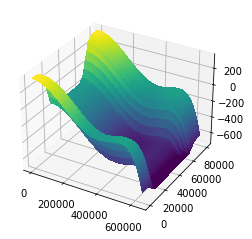

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
fig = plt.figure()
axes = fig.add_subplot(projection='3d')
firedrake.trisurf(z_b, axes=axes);

And again we'll use the same fluidity, friction, and accumulation rates.

In [5]:
A = Constant(20)
C = Constant(1e-2)

In [6]:
from firedrake import sqrt, inner
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    gravity as g,
    weertman_sliding_law as m
)

def friction(**kwargs):
    variables = ('velocity', 'thickness', 'surface', 'friction')
    u, h, s, C = map(kwargs.get, variables)

    p_W = ρ_W * g * max_value(0, -(s - h))
    p_I = ρ_I * g * h
    N = max_value(0, p_I - p_W)
    τ_c = N / 2

    u_c = (τ_c / C)**m
    u_b = sqrt(inner(u, u))

    return τ_c * ((u_c**(1/m + 1) + u_b**(1/m + 1))**(m / (m + 1)) - u_c)

In [7]:
a = Constant(0.3)

And once again we'll start out using the ice stream solver.
We won't look at the hybrid solver in this demo, but a steady state for the ice stream model is a good start on the way to computing a steady state for the hybrid model.

In [8]:
import icepack
model = icepack.models.IceStream(friction=friction)

In [9]:
h_0 = interpolate(Constant(100), Q1)
s_0 = icepack.compute_surface(thickness=h_0, bed=z_b)

Once again, we'll be running the same simulation several times, so it helps to wrap this up in a function.

In [10]:
import tqdm
from firedrake import dx
area = firedrake.assemble(Constant(1) * dx(mesh))

message = "avg, min thickness: {:4.2f}, {:4.2f}"
def run_simulation(solver, h, s, u, time, dt):
    num_steps = int(final_time / dt)
    progress_bar = tqdm.trange(num_steps)
    for step in progress_bar:
        h = solver.prognostic_solve(
            dt,
            thickness=h,
            velocity=u,
            accumulation=a,
            thickness_inflow=h_0
        )
        s = icepack.compute_surface(thickness=h, bed=z_b)

        u = solver.diagnostic_solve(
            velocity=u,
            thickness=h,
            surface=s,
            fluidity=A,
            friction=C
        )

        min_thickness = h.dat.data_ro.min()
        avg_thickness = firedrake.assemble(h * dx) / area
        progress_bar.set_description(message.format(avg_thickness, min_thickness))
        
    return h, s, u

And once again we'll need to build a solver to get an initial value of the ice velocity.
For this demonstration we'll default to using the trust region method and a direct solver for the diagnostic model rather than the iterative solvers shown in the previous guide.
The goal here is more to show how to use checkpoint files than to tweak performance.

In [11]:
dt = 5.
final_time = 3600

In [12]:
from firedrake import as_vector
opts = {
    'dirichlet_ids': [1],
    'side_wall_ids': [3, 4],
    'diagnostic_solver_type': 'petsc',
    'diagnostic_solver_parameters': {
        'snes_type': 'newtontr',
        'ksp_type': 'preonly',
        'pc_type': 'lu',
        'pc_factor_mat_solver_type': 'mumps'
    },
    'prognostic_solver_parameters': {
        'ksp_type': 'gmres',
        'pc_type': 'ilu'
    }
}
solver = icepack.solvers.FlowSolver(model, **opts)

x = firedrake.SpatialCoordinate(mesh)[0]
u_0 = solver.diagnostic_solve(
    velocity=interpolate(as_vector((90 * x / Lx, 0)), V1),
    thickness=h_0,
    surface=s_0,
    fluidity=A,
    friction=C
)

### First spin-up phase

Now for new things!
Firedrake includes functionality for saving simulation results to disk using the HDF5 file format.
HDF5 is a convenient file format for these types of problems because the library handles low-level binary twiddling like endianness for you, it's easy to inspect the contents and get a feel for what an HDF5 archive contains, and it has very efficient compression algorithm.
These features are wrapped up in the Firedrake class `DumbCheckpoint`.
The checkpoint is a little dumb because all it does is write the vector of coefficients in a field's finite element basis.
It doesn't write out the mesh, the function spaces, or information about the partitioning of the degrees of freedom if running in parallel.
It's on you as the user to correctly load and store from the same mesh and function spaces.
(The Firedrake team recently as of 21 Sept 2020 won a grant to improve the I/O capabilities and these shortcomings are going to be addressed very soon).
Nonetheless, it's good enough for our purposes as long as we exercise a bit of care.

Rather than run the simulation unconditionally, we'll first see if a checkpoint file `mismip-degree1.h5` exists on disk.
If it isn't there, we'll run the simulation and save the results to this file.
If it is there, we'll instead load the already-computed results.
The important thing to notice here is that we have to use the same names when we store and load these fields.

In [13]:
import os

if not os.path.exists('mismip-degree1.h5'):
    h, s, u = run_simulation(
        solver, h_0, s_0, u_0, final_time, dt
    )
    
    with firedrake.DumbCheckpoint(
        'mismip-degree1', mode=firedrake.FILE_CREATE
    ) as checkpoint:
        checkpoint.store(h, name='thickness')
        checkpoint.store(s, name='surface')
        checkpoint.store(u, name='velocity')

else:
    h = firedrake.Function(Q1)
    s = firedrake.Function(Q1)
    u = firedrake.Function(V1)
    
    with firedrake.DumbCheckpoint(
        'mismip-degree1', mode=firedrake.FILE_READ
    ) as checkpoint:
        checkpoint.load(h, name='thickness')
        checkpoint.load(s, name='surface')
        checkpoint.load(u, name='velocity')

We've run the model forward by 3600 years.
This isn't quite enough to get to steady state.
Near the shear margins, the ice thickness can get very thin -- on the order of 1-10 m -- after a few thousand years.
At the low spatial resolution we're using for this run, the system can even develop negative ice thicknesses.
(This unphysical feature can be eliminated by clamping the thickness from below at every timestep.)
Checkpointing makes it easy for us to resume the spin-up at higher spatial resolution without having to re-run the coarser phase again and again.

If you run this notebook again, you'll see that the simulation doesn't run a second time; the results just get loaded from disk.

### Second spin-up phase

Now that we've propagated out most of the initial transients, we can take our results with a piecewise linear basis, interpolate them into a piecewise quadratic basis, and resume the simulation for several thousand years more.
Since the system is much closer to steady state than it was at initialization, the nonlinear solver doesn't have to work as hard to calculate a velocity field.

In [14]:
Q2 = firedrake.FunctionSpace(mesh, family='CG', degree=2)
V2 = firedrake.VectorFunctionSpace(mesh, family='CG', degree=2)

In [15]:
h_0 = firedrake.interpolate(h, Q2)
s_0 = firedrake.interpolate(s, Q2)
u_0 = firedrake.interpolate(u, V2)
z_b = firedrake.interpolate(mismip_bed(mesh), Q2)

The old solver object was set up for the degree-1 discretization.
To continue, we'll need to create and set up a fresh solver object that stores the right internal data for the finer degree-2 discretization.

In [16]:
solver = icepack.solvers.FlowSolver(model, **opts)

In [17]:
final_time = 3600
dt = 4.

h, s, u = run_simulation(
    solver, h_0, s_0, u_0, final_time, dt
)

avg, min thickness: 1042.96, 18.98: 100%|██████████| 900/900 [18:51<00:00,  1.26s/it]


We can see some interesting features if we look at the thickness change from the start to the end of the simulation.
At the left side of the domain on the inflow boundary, the ice is still thickening even after several thousand years.
This part of the domain takes the longest time to relax to steady state.
Meanwhile at the floating terminus of the glacier on the right the system has more or less found its equilibrium.
The largest adjustments are near the grounding line and at the very thin ice in the shear margins.
These changes are more likely from the increased resolution of the quadratic basis functions over the linear basis functions.

In [18]:
δh = firedrake.interpolate(h - h_0, Q2)

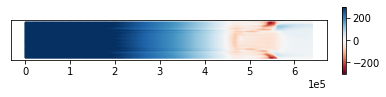

In [19]:
import icepack.plot
fig, axes = icepack.plot.subplots()
axes.get_yaxis().set_visible(False)
triangles = icepack.plot.tripcolor(
    δh, vmin=-300, vmax=+300, shading='gouraud', cmap='RdBu', axes=axes
)
fig.colorbar(triangles, fraction=0.01, pad=0.046);

Finally, we can save these results to another checkpoint file in order to continue to later phases of the simulation.

In [20]:
with firedrake.DumbCheckpoint(
    'mismip-degree2', mode=firedrake.FILE_CREATE
) as checkpoint:
    checkpoint.store(h, name='thickness')
    checkpoint.store(s, name='surface')
    checkpoint.store(u, name='velocity')

### Conclusion

The demonstrations we've shown so far have done all of the simulation and analysis in the same notebook.
This is handy for educational purposes, but it might not be an ideal workflow if you're doing big expensive simulations.
For that use case, it can be more conevenient for you to use one script for the simulation that saves the results to an HDF5 file at the end and do all the post-processing, analysis, and visualization in a notebook or in another script.
As we've shown here, you might understand one part of a multi-stage simulation but still be debugging the numerics for a latter stage, and checkpointing the earlier stage is useful for saving time as well.
Tools like [Make](https://www.gnu.org/software/make/) or [snakemake](https://snakemake.readthedocs.io/en/stable/) can be really handy for orchestrating these kinds of processing pipelines.